# Anomaly Detection Modeling for Quality Assessment

Using a variational auto-encoder we will determine if we can assess an image as high quality or low quality for use in a downstream task.  The hypothesis here is that differences in error when recreating the classes of images may indicate a difference in quality.

## Data Preparation

In [1]:
from google.colab import drive
from zipfile import ZipFile

import shutil

drive.mount('/content/drive') # for google colab. adjust accordingly
PARENT_DIR = '/content/drive/MyDrive/Wildtrack Group/IQA' 

# copy annotated and cropped images imafea
shutil.copy(PARENT_DIR + '/data/Annotated_Cropped_WildTrack.zip', 'Cropped_WildTrack.zip')

# extract zip file
with ZipFile('Cropped_WildTrack.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

Mounted at /content/drive


In [2]:
import torch
import torchvision
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import json
import numpy as np
import albumentations as A

# get downstream/classification task model files
shutil.copy(PARENT_DIR + '/final_model/transforms.json','transforms.json')
shutil.copy(PARENT_DIR + '/final_model/species_model.pt', 'species_model.pt')
shutil.copy(PARENT_DIR + '/final_model/class_mapping.json', 'class_mapping.json')

device = torch.device('cpu')

with open('class_mapping.json') as data:
    mappings = json.load(data)

class_mapping = {item['model_idx']: item['class_name'] for item in mappings}
model = torch.jit.load('species_model.pt').to(device)
transforms = A.load('transforms.json')

In [3]:
from torch.utils import data
import csv
import random
import torch
import yaml
import os

from time import process_time
from torch.utils.data import Dataset

data_dir = 'RAW/'

def get_key(val, item_dict):
    for key, value in item_dict.items():
        if val == value:
            return key
    return -1

def convert_image(img_test):
    image = Image.open(img_test)
    bands = image.getbands()
    if len(bands) == 1:
      image = image.convert(mode='RGB')
    image = np.array(image)
    image = transforms(image=image)['image']
    return image

def generate_data_sets(sample_percentage=1):

    image_reference_list = []
    subdirectories = list(os.walk(data_dir, topdown=False))[:-1]

    seed = 1234
    random.Random(seed).shuffle(subdirectories)
    subdirectories_idx = int(len(subdirectories) * sample_percentage) 
    subdirectories = subdirectories[:subdirectories_idx]

    for subdir in subdirectories:
        image_location = subdir[0]
        images = subdir[2]
        species_rating = image_location.rsplit('/', 1)[-1].replace('_', ' ')
        subjective_score = int(species_rating.rsplit(' ', 1)[-1])
        species_class = species_rating.rsplit(' ', 1)[:-1][0]

        if len(species_class.rsplit(' ', 1)) > 1:
            species = species_class.rsplit(' ')[0]
            animal_class = ' '.join(species_class.rsplit(' ')[1:])
        else:
            animal_class = 'Unknown'
            species = species_class

        for image in images:
            class_name = species if animal_class == 'Unknown' else species + ': ' + animal_class
            class_index = get_key(class_name, class_mapping)
            if class_index > -1:
              image_name = image_location +'/'+ image
              image_data = convert_image(image_name)
              model_input = torch.from_numpy(image_data).to(device)
              obs = model_input.permute(2, 0, 1).unsqueeze(dim=0).float()
              y_pred = model(obs)
              y_pred = y_pred.argmax(dim=1).squeeze().item()
              classifiable = 1 if class_index == y_pred else 0
              image_reference = (image_location, image, species, animal_class, image_data, classifiable)
              image_reference_list.append(image_reference)

    train_index = int(len(image_reference_list) * 0.6 )
    test_index = -int(len(image_reference_list) * 0.2 ) 
    val_index = test_index * 2
    training = image_reference_list[:train_index]
    validation = image_reference_list[val_index:test_index]
    testing = image_reference_list[test_index:]

    return training, validation, testing



In [4]:
train, validation, test = generate_data_sets(sample_percentage=1)

## Build Model

### Define Encoder Network

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2
encoder_inputs = keras.Input(shape=(512, 512, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [6]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  18496       ['conv2d[0][0]']                 
                                )                                                           

### Define Latent Space Sampler

In [7]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Define Decoder Network

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 128 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((128, 128, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(3, 3, activation="relu", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [9]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1048576)           3145728   
                                                                 
 reshape (Reshape)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 64)     36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 512, 512, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 3)       867 

### Build VAE

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.mse = keras.losses.MeanSquaredError(reduction=keras.losses.Reduction.SUM)
        self.layer = layers.Normalization(axis=None)
        self.layer.adapt(np.arange(0, 256, dtype=int))


    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    
    def train_step(self, data):
        x, y = data
        x = self.layer(x)
        y = self.layer(y)

        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            reconstruction_loss = self.mse(y, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        x = self.layer(x)
        y = self.layer(y)
        # Compute predictions
        z_mean, z_log_var = self.encoder(x)
        z = self.sampler(z_mean, z_log_var)
        reconstruction = decoder(z)
        reconstruction_loss = self.mse(y, reconstruction)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        return {
          "total_loss": total_loss,
          "reconstruction_loss": reconstruction_loss,
          "kl_loss": kl_loss,
        }

## Model Training

In [11]:
# Prepare training data

X_train = np.array([item[4] for item in train])
y_train = np.array([item[5] for item in train])

X_val = np.array([item[4] for item in validation])
y_val = np.array([item[5] for item in validation])

X_test = np.array([item[4] for item in test])
y_test = np.array([item[5] for item in test])

X_usable_train, X_reject_train = X_train[y_train == 1], X_train[y_train == 0]
X_usable_val, X_reject_val = X_val[y_val == 1], X_val[y_val == 0]
X_usable_test, X_reject_test = X_test[y_test == 1], X_test[y_test == 0]

In [12]:
# Train the autoencoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# We pass the same value for x and y because we want to recreate the input, Basically f(x) = x
tf_train = tf.data.Dataset.from_tensor_slices((X_usable_train, X_usable_train)).batch(64)
tf_val = tf.data.Dataset.from_tensor_slices((X_usable_val, X_usable_val)).batch(64)
tf_test = tf.data.Dataset.from_tensor_slices((X_usable_test, X_usable_test)).batch(64)

earlystopper = EarlyStopping(monitor='val_total_loss', mode='min', min_delta=0.005, patience=5, verbose=0, restore_best_weights=True)
max_epochs = 2
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00000001), run_eagerly=True)
hist = vae.fit(tf_train, epochs=max_epochs,  shuffle=True, callbacks=[earlystopper], validation_data=tf_val)

Epoch 1/2
30/30 [==============================] - 574s 19s/step - total_loss: 7733721.5000 - reconstruction_loss: 7733721.5000 - kl_loss: 0.0117 - val_total_loss: 546419.3750 - val_reconstruction_loss: 546419.3750 - val_kl_loss: 0.0231
Epoch 2/2
30/30 [==============================] - 573s 19s/step - total_loss: 7733737.0000 - reconstruction_loss: 7733737.0000 - kl_loss: 0.0120 - val_total_loss: 546413.9375 - val_reconstruction_loss: 546413.9375 - val_kl_loss: 0.0239


In [55]:
X_sample_test = X_test[0:300]
y_sample_test = y_test[0:300]
z_mean, z_log_var = vae.encoder(X_sample_test)
sample = vae.sampler(z_mean, z_log_var)
decoded = vae.decoder(sample)

mse = np.mean(np.power(X_sample_test - decoded, 2), axis=1)
sum_mse = np.array([np.matrix(item).sum() for item in mse])

## Data Analysis

The goal is to assess the mean squared error when attempting to recreate the image, separated by data that could be classified by the model vs data that could not be classified (noted as 1 and 0 respectively). 

In [56]:
import pandas as pd

# gather the mean square error calculated from the model and align with classification ability
error_df_test = pd.DataFrame({'mse': sum_mse, 'class': y_sample_test})
error_df_test.describe()

,mse,class
count,3.000000e+02,300.000000
mean,8.215736e+12,0.700000
std,1.423003e+14,0.459023
min,4.008070e+06,0.000000
25%,2.375723e+07,0.000000
50%,2.866263e+07,1.000000
75%,3.343599e+07,1.000000
max,2.464713e+15,1.000000


In [58]:
# group data by classification and calculate basic statistics for mse
group_calculation = error_df_test[['mse','class']].groupby("class").describe()
group_calculation

mse                                                                  \
       count          mean           std         min         25%         50%   
class                                                                          
0       90.0  2.677078e+07  6.436666e+06  4008069.75  23276244.0  27340713.0   
1      210.0  1.173675e+13  1.700813e+14  6084006.00  24262699.0  29150687.0   

                                 
              75%           max  
class                            
0      31615378.5  3.864628e+07  
1      34098576.0  2.464713e+15

In [59]:
# there appears to be an outlier so we'll remove that data and recalculate stats
error_df_test = error_df_test[error_df_test['mse'] < 1.146474e+15]
group_calculation = error_df_test[['mse','class']].groupby("class").describe()
group_calculation

mse                                                             \
       count        mean        std         min         25%         50%   
class                                                                     
0       90.0  26770776.0  6436665.5  4008069.75  23276244.0  27340713.0   
1      209.0  28420316.0  7543768.5  6084006.00  24261532.0  29148872.0   

                               
              75%         max  
class                          
0      31615378.5  38646284.0  
1      34073256.0  43893256.0

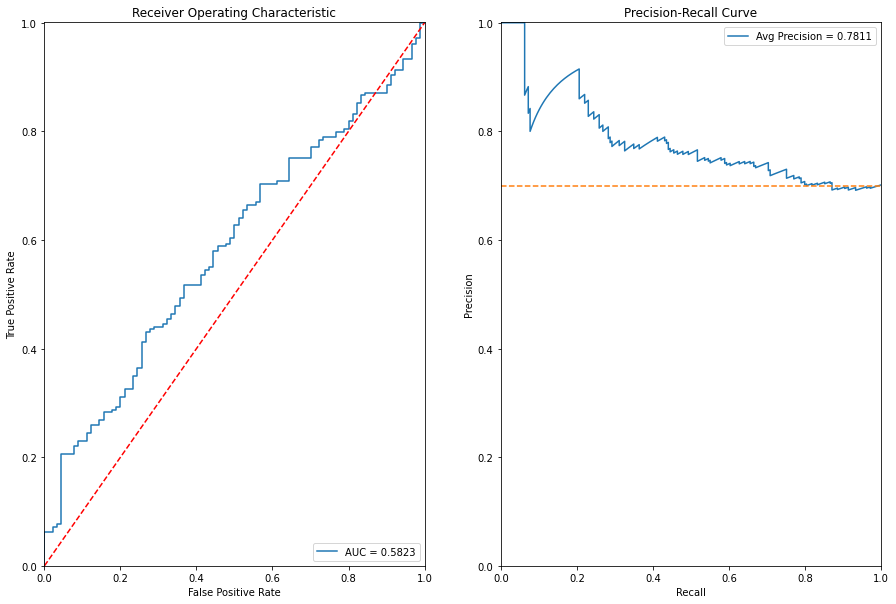

In [60]:
# Create a ROC and Precision Curve to assess how well we can claassify based on mse

from sklearn.metrics import confusion_matrix , roc_auc_score, roc_curve, auc, classification_report, average_precision_score, precision_recall_curve

fpr, tpr, thresholds = roc_curve(error_df_test['class'], error_df_test['mse'])
roc_auc = auc(fpr, tpr)

precision, recall, thresholds = precision_recall_curve(error_df_test['class'], error_df_test['mse'])
avg_pr = average_precision_score(error_df_test['class'], error_df_test['mse'])

no_skill = len(error_df_test['class'][error_df_test['class']==1]) / len(error_df_test['class'])

fig, axs = plt.subplots(1, 2, figsize=(15,10))
axs[0].set_title('Receiver Operating Characteristic')
axs[0].plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
axs[0].legend(loc='lower right')
axs[0].plot([0,1],[0,1],'r--')
axs[0].set_xlim([-0.001, 1])
axs[0].set_ylim([0, 1.001])
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')

axs[1].set_title('Precision-Recall Curve')
axs[1].plot(recall, precision, label='Avg Precision = %0.4f'% avg_pr)
axs[1].legend(loc='upper right')
axs[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
axs[1].set_xlim([-0.001, 1])
axs[1].set_ylim([0, 1.001])
axs[1].set_ylabel('Precision')
axs[1].set_xlabel('Recall')
plt.show();

AUC indicates that prediction is better than average overall, with a precision of .78 . So this method may have some validity

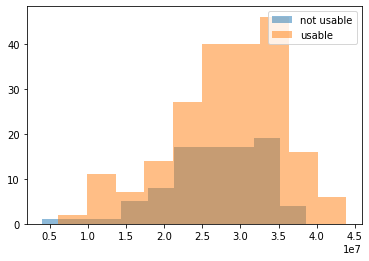

In [61]:
# Graph data to see if there is a clear threshold revealed between clasifiable non-classifiable images

classifiable = error_df_test[(error_df_test['class'] == 1)].mse.values
not_classifiable = error_df_test[(error_df_test['class'] == 0)].mse.values

plt.hist(not_classifiable, bins=10, alpha=0.5, label='not usable')
plt.hist(classifiable, bins=10, alpha=0.5, label='usable')
plt.legend(loc='upper right')
plt.show()


There is significant overlap except for data that has an mse higher than 3.8e7. We'll dig a bit deeper to determine what is the best threshold to use for both precision and recall when determining high quality images.

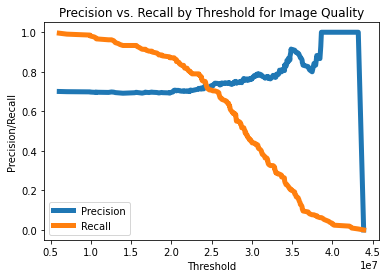

In [73]:
import warnings
warnings.filterwarnings("ignore")

#Let's evaluate for best threshold using precision/recall measures
precisions = []
recalls = []

for threshold in thresholds:
  predictions = [1 if x > threshold else 0 for x in error_df_test["mse"]]
  classification = classification_report(error_df_test["class"], predictions, output_dict=True)['1']
  precisions.append(classification['precision'])
  recalls.append(classification['recall'])

plt.plot(thresholds, precisions, label="Precision",linewidth=5)
plt.plot(thresholds, recalls, label="Recall",linewidth=5)
plt.title('Precision vs. Recall by Threshold for Image Quality')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

The optimal threshold to use for prediction is the point where both precision and recall are at it's best.  In reviewing the above chart this appears at approximately mse 2.5e7. For predictions we will use that to identify high quality images vs low quality and review the results

In [68]:
predictions = [1 if x > 2.5e+07 else 0 for x in error_df_test["mse"]]

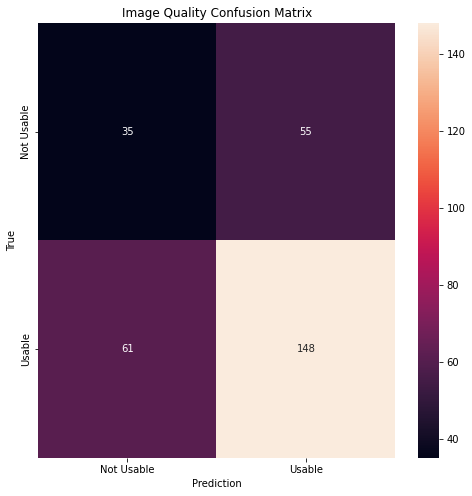

In [69]:
import seaborn as sns
labels = ["Not Usable","Usable"]
conf_matrix = confusion_matrix(error_df_test['class'],predictions)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Image Quality Confusion Matrix")
plt.ylabel('True')
plt.xlabel('Prediction')
plt.show()

In [70]:
print(classification_report(error_df_test["class"], predictions))

              precision    recall  f1-score   support

           0       0.36      0.39      0.38        90
           1       0.73      0.71      0.72       209

    accuracy                           0.61       299
   macro avg       0.55      0.55      0.55       299
weighted avg       0.62      0.61      0.62       299



The overall accuracy in this method is 61% accuracy in determining whether something is truly classifiable or not.  F1 Scores indicate it is better at determining when something is high quality vs not.
 